In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# --- LOADING DATA ---
df = pd.read_csv(r"D:\02 - PERSONAL\Projects\Tata Geldium Credit Delinquency\credit-delinquency\data\Delinquency_prediction_dataset.csv")
# print(df)
print(df.info())
# print(df.describe())

# --- CLEANING DATA ---
# Null cols : income 39, credit_score 2 , loan_balance 29
df["Credit_Score"] = df["Credit_Score"].fillna(df["Credit_Score"].median())
df["Loan_Balance"] = df["Loan_Balance"].fillna(df["Loan_Balance"].median())
df['Income'] = df.groupby('Employment_Status')['Income']\
                 .transform(lambda x: x.fillna(x.median()))

# Dataset balance --
counts = df["Delinquent_Account"].value_counts()
percentages = df["Delinquent_Account"].value_counts(normalize=True) * 100
result = pd.DataFrame({
    "Count": counts,
    "Percentage (%)": percentages.round(2)
})
print(result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_ID           500 non-null    object 
 1   Age                   500 non-null    int64  
 2   Income                461 non-null    float64
 3   Credit_Score          498 non-null    float64
 4   Credit_Utilization    500 non-null    float64
 5   Missed_Payments       500 non-null    int64  
 6   Delinquent_Account    500 non-null    int64  
 7   Loan_Balance          471 non-null    float64
 8   Debt_to_Income_Ratio  500 non-null    float64
 9   Employment_Status     500 non-null    object 
 10  Account_Tenure        500 non-null    int64  
 11  Credit_Card_Type      500 non-null    object 
 12  Location              500 non-null    object 
 13  Month_1               500 non-null    object 
 14  Month_2               500 non-null    object 
 15  Month_3               5

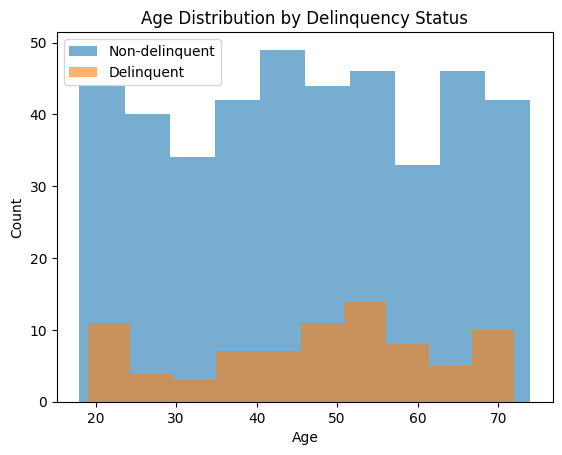

C:\Users\Bhavya Lakhani\AppData\Local\Temp\ipykernel_20844\1446897903.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  delinquency_rate = df.groupby('Income_Bin')['Delinquent_Account'].mean()


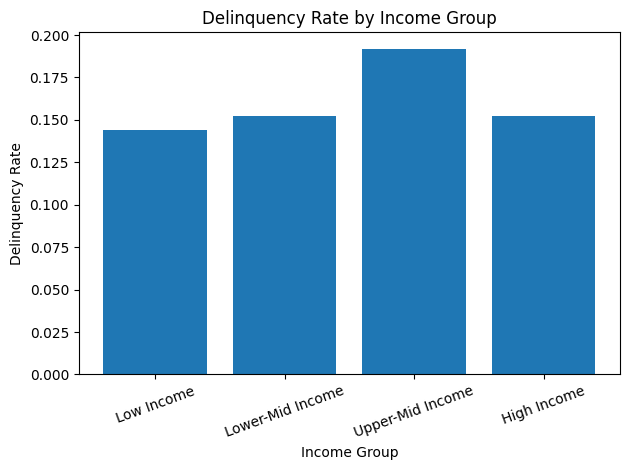

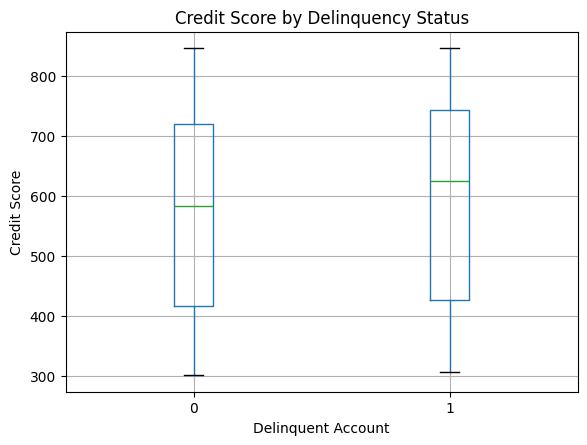

C:\Users\Bhavya Lakhani\AppData\Local\Temp\ipykernel_20844\1446897903.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('DTI_Bin')['Delinquent_Account'].mean().plot(kind='bar')


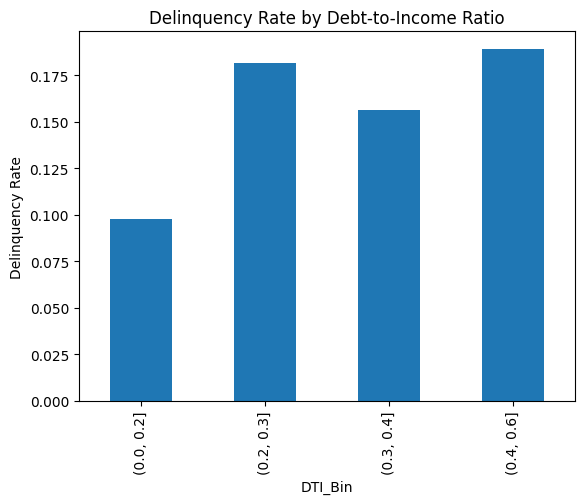

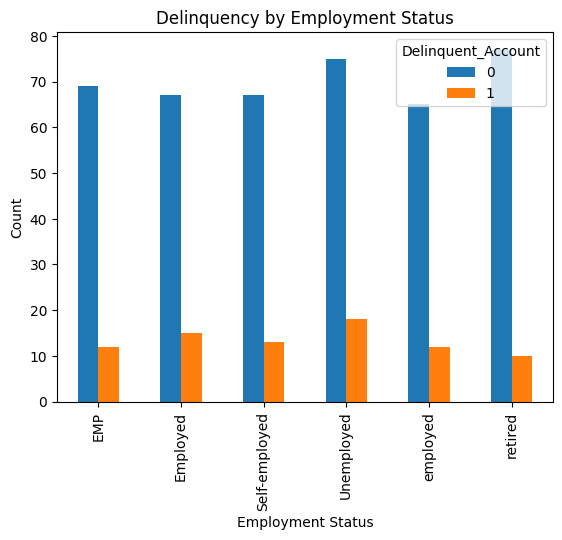

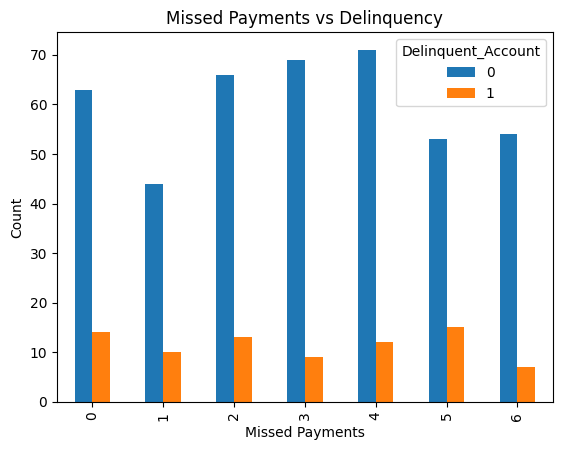

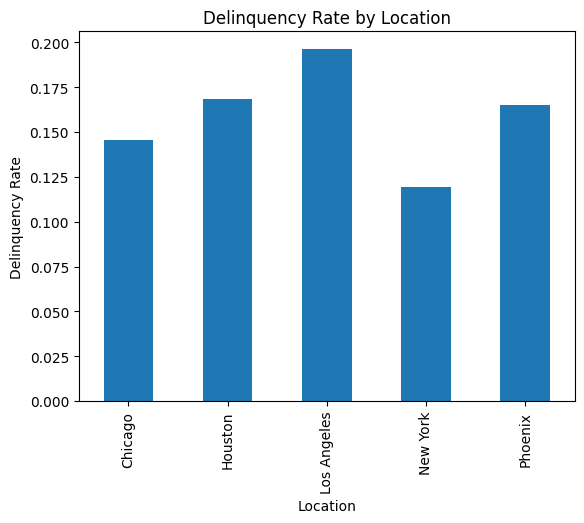

In [19]:
# --- PLOTS ---

# Age vs Delinquency : 
plt.hist(df[df['Delinquent_Account']==0]['Age'], alpha=0.6, label='Non-delinquent')
plt.hist(df[df['Delinquent_Account']==1]['Age'], alpha=0.6, label='Delinquent')
plt.legend()
plt.title("Age Distribution by Delinquency Status")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Income vs Delinquency : 
# Create income bins using quantiles (equal-sized groups)
df['Income_Bin'] = pd.qcut(
    df['Income'],
    q=4,
    labels=['Low Income', 'Lower-Mid Income', 'Upper-Mid Income', 'High Income']
)
# Calculate delinquency rate per income bin
delinquency_rate = df.groupby('Income_Bin')['Delinquent_Account'].mean()
plt.figure()
plt.bar(delinquency_rate.index, delinquency_rate.values)
plt.xlabel('Income Group')
plt.ylabel('Delinquency Rate')
plt.title('Delinquency Rate by Income Group')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Credit Score vs Delinquency : 
df.boxplot(column='Credit_Score', by='Delinquent_Account')
plt.title("Credit Score by Delinquency Status")
plt.suptitle("")
plt.xlabel("Delinquent Account")
plt.ylabel("Credit Score")
plt.show()

# Debt-to-income ratio vs Delinquency : 
df['DTI_Bin'] = pd.cut(
    df['Debt_to_Income_Ratio'],
    bins=[0, 0.2, 0.3, 0.4, 0.6]
)
df.groupby('DTI_Bin')['Delinquent_Account'].mean().plot(kind='bar')
plt.ylabel("Delinquency Rate")
plt.title("Delinquency Rate by Debt-to-Income Ratio")
plt.show()

# Employment vs Delinquency : 
pd.crosstab(df['Employment_Status'], df['Delinquent_Account']).plot(kind='bar')
plt.title("Delinquency by Employment Status")
plt.xlabel("Employment Status")
plt.ylabel("Count")
plt.show()

# Missed Payments vs Delinquency : 
pd.crosstab(df['Missed_Payments'], df['Delinquent_Account']).plot(kind='bar')
plt.title("Missed Payments vs Delinquency")
plt.xlabel("Missed Payments")
plt.ylabel("Count")
plt.show()

# Location vs Deliquency :
df.groupby('Location')['Delinquent_Account'].mean().plot(kind='bar')
plt.ylabel("Delinquency Rate")
plt.title("Delinquency Rate by Location")
plt.show()

In [20]:
# --- MODEL ---
X = df.drop(columns=["Delinquent_Account"], axis=1)
y = df["Delinquent_Account"]

cat_cols = X.select_dtypes(include='object').columns 
num_cols = X.select_dtypes(exclude='object').columns 

# One hot labeling
X = pd.get_dummies(X, drop_first=True)

# Model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"""
📌 Rule:
fit_transform → train only
transform → test only
"""
model = LogisticRegression()
model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000
)
model.fit(X_train_scaled, y_train)
y_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= 0.3).astype(int)

# print("Actual labels:", np.unique(y_test, return_counts=True))
# print("Predicted labels:", np.unique(y_pred, return_counts=True))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))
print(roc_auc_score(y_test, y_pred))

[[86  0]
 [14  0]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        86
           1       0.00      0.00      0.00        14

    accuracy                           0.86       100
   macro avg       0.43      0.50      0.46       100
weighted avg       0.74      0.86      0.80       100

0.5


The dataset is moderately clean but contains missing values in key financial variables such as income, loan balance, and credit score. Income has the highest proportion of missing values, which could bias delinquency analysis if not handled carefully. Credit score and loan balance, despite fewer missing values, are critical predictors and require appropriate imputation. No major inconsistencies or duplicate records were observed. Overall, the dataset is suitable for modeling after addressing these data quality issues.

**🔴 High-risk indicators -**<br>
**Low credit score:** Customers with lower credit scores are more likely to miss payments due to prior credit risk history.<br>
**High loan balance:** Larger outstanding balances increase monthly repayment stress.<br>
**Low income or unstable employment:** Borrowers with irregular income face higher delinquency risk.<br>
**High credit utilization:** Indicates financial strain and over-leveraging.

**Handling Missing values :** Since missingness was below 10% and features were numeric and skewed, I used median imputation to preserve distribution robustness and avoid outlier bias.

**Encoding :** For this project, I used pd.get_dummies for categorical encoding since the dataset was small and static. In a production setting, I’d use ColumnTransformer with OneHotEncoder to avoid train–test mismatch.

**Regression :** Linear Regression predicts “how much”, Logistic Regression predicts “how likely”.

**Using Balanced Logistic Regression :** Since delinquency is a class-imbalanced and high-risk problem, I used Logistic Regression with class_weight='balanced' to improve recall for delinquent accounts.

**Your F1-score is only 0.57, isn’t that low?** 
For an imbalanced delinquency dataset, an F1 of 0.57 with 100% recall is a solid baseline. The model prioritizes catching all defaulters, and precision can be improved through threshold tuning or tree-based models.

The EDA reveals that while the dataset is largely consistent, missing values in key financial features require careful treatment. Credit score, loan balance, and income emerge as primary risk indicators. Addressing these data quality issues will improve the robustness of Geldium’s delinquency prediction.<br>
🔴 Despite correct preprocessing and class balancing, the logistic regression baseline failed to confidently identify delinquent customers, indicating limited linear separability in the data and motivating threshold tuning and consideration of more expressive models.